---
title: Architecture
description: Explains the architecture of the BPTK-Py business simulation framework, as it applies to Agent-based modeling and System Dynamics.
keywords: agent-based modeling, abm, bptk, bptk-py, python, business simulation
---

# The Architecture Of The BPTK_PY Framework

This document explains the overall architecture of the BPTK framework.

## BPTK Building Blocks

The BPTK framework was designed to meet a number of objectives:

* Provide the modeler and analyst working in a Jupyter notebook environment with a easy to use API, bearing in mind that such analysts may not be expert Python developers.
* Provide the ability to run simulations standalone (i.e. outside of a notebook environment)
* Focus on modeling and simulation and reuse libraries such as [Pandas](http://pandas.pydata.org) and [Matplotlib](http://www.matplotlib.org) for manipulating and plotting simulation results.

Currently the framework has five conceptual building blocks:

* *ABM and SD Modeling.* A component that allows you to build and run simulations in Python, using an Agent-based modeling approach, a System Dynamics modelling approach or both ("hybrid models"). This component contains a number of classes that you will need to build such models - please read the notebooks on [agent-based modeling](../../../abm/in-depth/in_depth_agent_based_modeling/in_depth_agent_based_modeling.ipynb) and [System Dynamics modeling](../../../sd-dsl/in-depth/in_depth_simple_python_library_sd_dsl/in_depth_simple_python_library_sd_dsl.ipynb) to learn more about these classes.
* *SD Transpiler.* A component that (automatically) translates System Dynamic models conforming to the XMILE standard into Python code.
* *Scenario Management.* A component that lets you define and manage simulation scenarios in a uniform manner. A scenario is a model and a set of initial values for the simulation parameters. Scenarios are a powerful tool, because they enable you to easily compare the results of running the same simulation with different parameters to each other, which is something you have to do frequently when working with simulations.
* *Visualisation.* A component that visualises the results produced by simulations, in the form of plots or dashboards.
* *BPTK API.* A high level API that lets you interact with the other components using a simple and uniform API. In particular, this component allows you to run scenarios and plot scenario results from both models created in Python or translated from XMILE in a uniform manner.

To use the framework, the modeler needs to build simulation models, either directly Python (AB/SD Model) or in XMILE (using an XMILE compatible SD modeling tool, such as isee systems Stella). A model created in Python is essentially a subclass of the AB and SD Modeling component, while the XMILE models are transpiled into such a subclass by the SD Transpiler component.

How does the framework know which models to compile? This is what the scenario config files are for - the modeler uses these to define scenario parameters and to identify the model that is relevant for a particular scenario. The model is then either the name of a Python class or the name of an XMILE model.

The diagram below shows these building blocks and their dependencies.

![BPTK Components](BPTK_Components.png)

## How The Components Work Together At Runtime

Now let's see what happens at runtime, assuming that we are in a Jupyter notebook.

First of all we initialize the framework by creating a ``bptk`` object. This automatically causes the framework to read all scenario config files from the ``scenario`` directory. The location of this directory can be configured in the frameworks config file.

In [1]:
## BPTK Package
from BPTK_Py.bptk import bptk 

bptk = bptk()

Depending on whether a scenario relates to a Python model or an XMILE model, the scenario will either be a correctly configured instance of the Python model or it will contain all the equations transpiled from the XMILE model.

At this stage, all scenario managers, scenarios and models have been instantiated and configured according to the scenario definitions, but the simulations have not run yet.

You can easily test the transpiler by deleting the transpiled Python classes from the scenario manager directory - the scenario manager notices this and automatically re-transpiles the model. This behaviour is particularly useful when building XMILE models and testing scenarios in a Jupyter notebook in parallel. As soon as you change the XMILE model, the model is re-transpiled into Python. Now all you need to do is reset the model in the Jupyter notebook and the Python class is then automatically reloaded.


The following piece of code lists all the scenarios that have been loaded:

In [2]:
print()
print("Available Scenario Managers and Scenarios:")
print()
managers = bptk.scenario_manager_factory.get_scenario_managers()

for key, manager in managers.items():
     print("")
     print("*** {} ***".format(key))

     for name in manager.get_scenario_names():
         print("\t {}".format(name))


Available Scenario Managers and Scenarios:


*** smSimpleProjectManagement ***
	 base
	 scenario100
	 scenario80
	 scenario120
	 scenario100WithPoints


Back to our discussion of ``bptk.plot_scenario``: So far, the scenarios have been loaded, but not simulated yet (which is good, because there could potentially be very many scenarios and you probably don't want to run them all at once).

To run a scenario, you could ``bptk.run_simulation`` with the appropriate parameters – this methods runs the given scenarios and returns a dataset. But in most cases you probably want to visualise the results directly, in which case ``bptk.plot_scenario`` is the method to use.

Let's choose one of the scenarios from the list above, e.g. the ``scenario120`` from the ``smSimpleProjectManagement`` scenario manager. You can run the simulation and plot the behaviour of the open tasks and closed tasks using the following command:

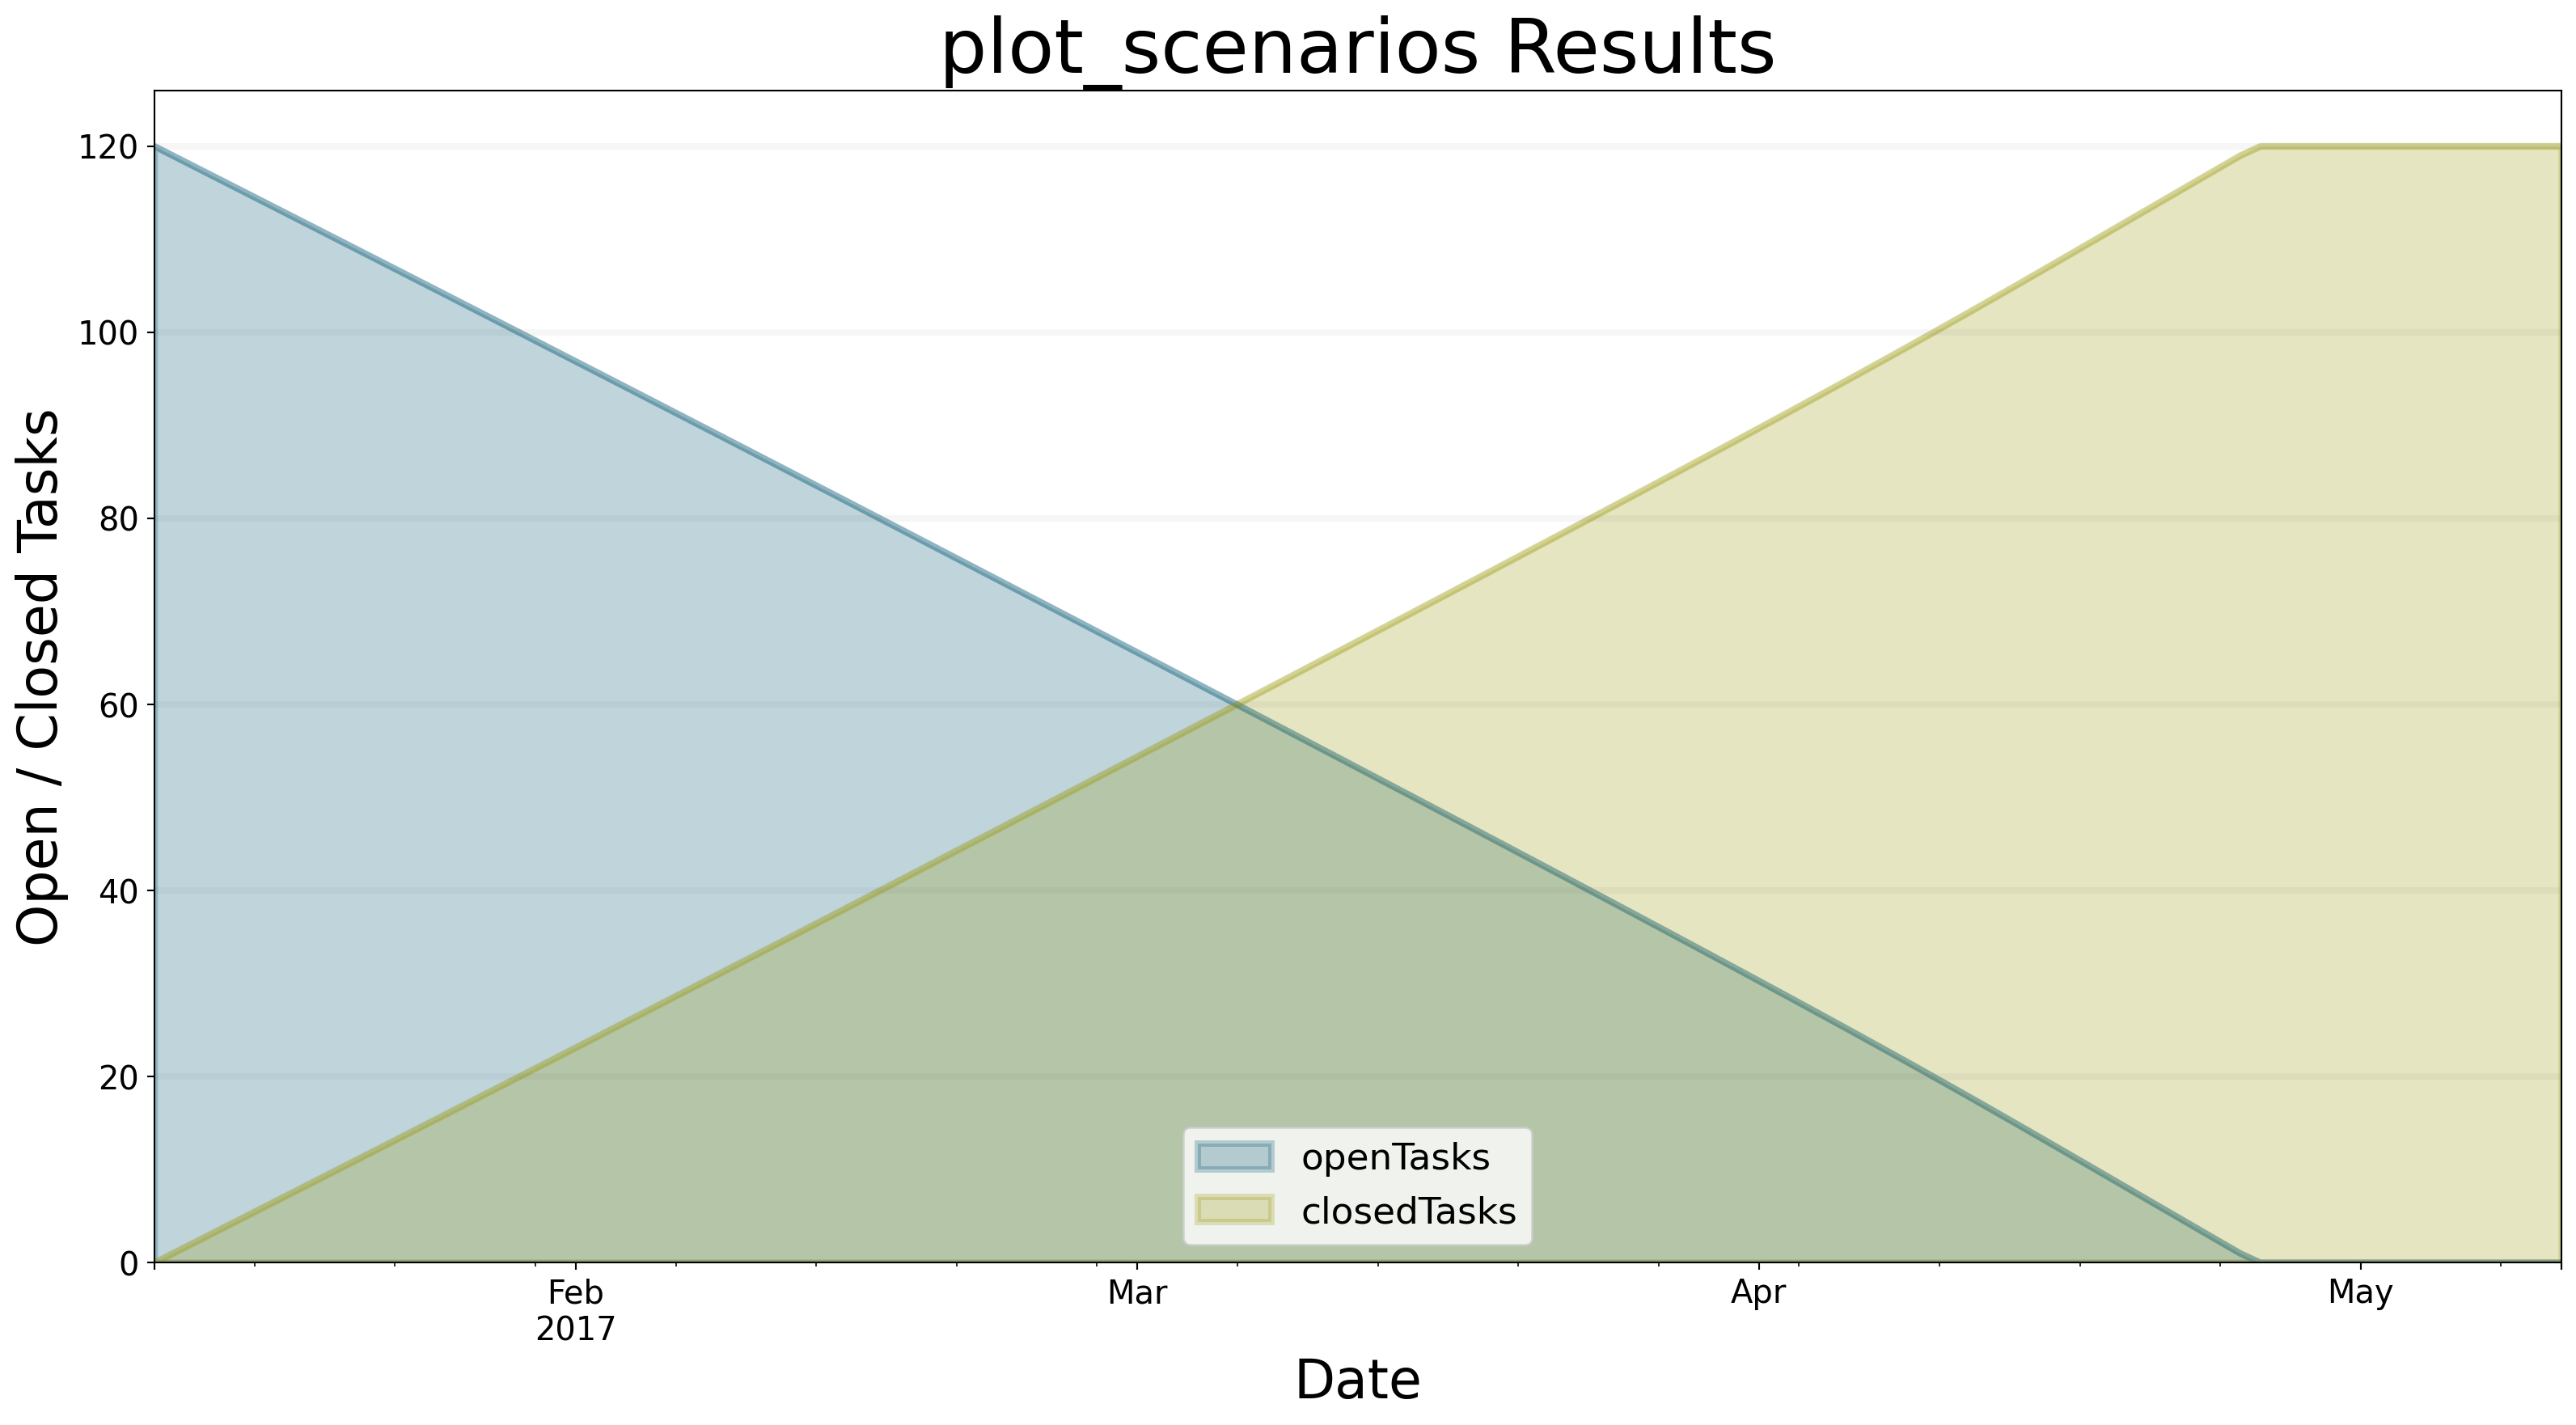

In [3]:
   bptk.plot_scenarios(
        scenario_managers=["smSimpleProjectManagement"],
        scenarios=["scenario120"],
        equations=['openTasks',"closedTasks"],
        title="plot_scenarios Results",
        x_label="Date",
        y_label="Open / Closed Tasks",
        start_date="1/11/2017",
        freq="D"
    )

What happens behind the scenes in order to produce this result?

As mentioned above, the ``bptk`` object doesn't contain much logic of its own, because we want to decouple the API from the components that actually *do* the heavy lifting.

The BPTK API calls the scenario manager to run the scenario.

The scenario manager checks its internal simulation cache to see whether the scenario has already been run - if so, it passes the dataframe containing the simulation results from the cache to the visualisation component, which creates the relevant plot.

This caching behaviour is essential – it means you do not need to re-run the scenario to plot the results from another equations or agent, you just need to look up the result in the cache. Without the cache, you would have to run the simulation again for every plot, which could take quite some time depending on the size and complexity of the model.

If there is no data in the cache, the scenario manager runs the scenario by calling its ``run`` method, and then passes the dataframe to the ``visualisation`` component.

## Summary

Even though the API of the ``bptk`` object is simple, there is actually quite a lot going on behind the scenes. Because the components only communicate via well-defined interfaces, the scenario manager can treat both ABM, native SD and transpiled SD models in a similar fashion. The framework could also be easily extended to deal with other kinds of simulations.
